# CS205 Spring 2015: HW 1
### Cole Diamond

In [104]:
%matplotlib inline

## Inner Product Computation

### Task

Create two random large arrays and evaluate the inner product of the two vectors.  The goal is to compute first in serial, then in parallel.  You can make simplifying assumptions as necessary for this lab.

The inner product formula is given by:

$$
\mathbf{a \cdot b} = \sum\limits_{k=0}^{K-1}a_k b_k
$$

### Implementation: Serial

In [5]:
%%writefile P1serial.py
import numpy as np
import time

def get_big_arrays():
  '''Generate two big random arrays.'''
  N = 12582912      # A big number, the size of the arrays.
  np.random.seed(0)  # Set the random seed
  return np.random.random(N), np.random.random(N)

def serial_dot(a, b):
  '''The dot-product of the arrays -- slow implementation using for-loop.'''
  result = 0
  for k in xrange(0, len(a)):
    result += a[k]*b[k]
  return result


if __name__ == '__main__':
  # Get big arrays
  a, b = get_big_arrays()

  # Compute the dot product in serial
  start_time = time.time()
  result = serial_dot(a, b)
  end_time = time.time()

  print "a*b = %f in %f seconds" % (result, end_time - start_time)

Overwriting P1serial.py


### Implementation: Parallel

In [318]:
%%writefile P1Parallel.py
from mpi4py import MPI
import numpy as np
import time

from P1serial import get_big_arrays, serial_dot

def parallel_dot(a, b, comm, p_root=0):
  '''The parallel dot-product of the arrays a and b.
  Assumes the arrays exist on process p_root and returns the result to
  process p_root.
  By default, p_root = process 0.'''
  rank = comm.Get_rank()
  size = comm.Get_size()

  # Broadcast the arrays to all processes
  a = comm.bcast(a, root=p_root)
  b = comm.bcast(b, root=p_root)

  # Save the number of tasks to a varaible
  numtasks = len(a)

  # Start and end indices of the local dot product
  # any issues here?
  # integer casts naturally floor
  # start = rank * int(numtasks / size)
  # end = ((rank+1) * int(numtasks / size)) if rank % size else ((rank+1) * int(numtasks / size))

  # sanity check print statements
  # print "Rank %d, start: %d, end: %d, num_elem: %d, size: %d" % (rank, start, end, end-start, numtasks)

  # Compute the partial dot product

  local_dot = serial_dot(a[rank::size], b[rank::size])

  # Reduce the partial results to the root process
  result = comm.reduce(local_dot, root=p_root)
  return result

if __name__ == '__main__':
  comm = MPI.COMM_WORLD
  rank = comm.Get_rank()

  # Get big arrays on process 0
  a, b = None, None
  if rank == 0:
    a, b = get_big_arrays()

  # Compute the dot product in parallel
  comm.barrier()
  p_start = MPI.Wtime()
  p_dot = parallel_dot(a, b, comm)
  comm.barrier()
  p_stop = MPI.Wtime()

  # Check and output results on process 0
  if rank == 0:
    s_start = time.time()
    s_dot = serial_dot(a, b)
    s_stop = time.time()
    print "Serial Time: %f secs" % (s_stop - s_start)
    print "Parallel Time: %f secs" % (p_stop - p_start)
    rel_error = abs(p_dot - s_dot) / abs(s_dot)
    print "Parallel Result = %f" % p_dot
    print "Serial Result   = %f" % s_dot
    print "Relative Error  = %e" % rel_error
    if rel_error > 1e-10:
      print "***LARGE ERROR - POSSIBLE FAILURE!***"

Overwriting P1Parallel.py


In [319]:
%%system 
mpiexec -n 4 python P1Parallel.py

['Serial Time: 4.398296 secs',
 'Parallel Time: 2.412834 secs',
 'Parallel Result = 3144543.496083',
 'Serial Result   = 3144543.496082',
 'Relative Error  = 2.246457e-13']

### Question

Hyperthreading would increase instruction-level parallelism but you still won’t see a speedup. Why? 

### Answer

Instruction-level paralellism refers to a latency-hiding strategy to execute lower-latency instructions in parallel with longer-latency instructions. These computations must not depend on each other. Usually, instruction-level parallelism is performed by the compiler, but it can be implemented in hardware. The parallelism is limited by the number of computations that can be performed that do not depend on each other. Hyperthreading will reduce the latency of the computations, but not by a significant order of magnitude.

Tomography 
======


In [1]:
%%writefile P2serial.py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
plt.ion()         # Allow interactive updates to the plots

class data_transformer:
  '''A class to transform a line of attenuated data into a back-projected image.
  Construct on the number of data points in a line of data and the number of
  pixels in the resulting square image. This precomputes the
  back-projection operator.
  Once constructed, call the transform method on a line of attenuated data and
  the angle that data represents to retrieve the back-projected image.'''
  def __init__(self, sample_size, image_size):
    '''Perform the required precomputation for the back-projection step.'''
    [self.X,self.Y] = np.meshgrid(np.linspace(-1,1,image_size),
                                  np.linspace(-1,1,image_size))
    self.proj_domain = np.linspace(-1,1,sample_size)
    self.f_scale = abs(np.fft.fftshift(np.linspace(-1,1,sample_size+1)[0:-1]))

  def transform(self, data, phi):
    '''Transform a data line taken at an angle phi to its back-projected image.
    Input: data, an array of sample_size values.
    Output: an image_size x image_size array -- the back-projected image'''
    # Compute the Fourier filtered data
    filtered_data = np.fft.ifft(np.fft.fft(data) * self.f_scale).real
    # Interpolate the data to the rotated image domain
    result = np.interp(self.X*np.cos(phi) + self.Y*np.sin(phi),
                       self.proj_domain, filtered_data)
    return result

def get_data(filepath):
    numrows, numcols = 2048, 6144
    dt = np.dtype(np.float64) 
    data = np.fromfile(filepath, dtype=dt).reshape((numrows, numcols)) 
    return data

if __name__ == '__main__':
    sample_size, image_size = 6144, 512
    data = get_data("PA1Distro/TomoData.bin")
    transformer = data_transformer(sample_size, image_size)
    result = reduce(lambda image, k: image + transformer.transform(data[k, :], -(k+1)*np.pi/sample_size), np.arange(2048))
    fig = plt.figure(figsize=(15,10),facecolor='w') 
    plt.imshow(result, cmap='bone')
    plt.imsave('P2serial.png', data, cmap='bone')

Overwriting P2serial.py


(2048, 6144)


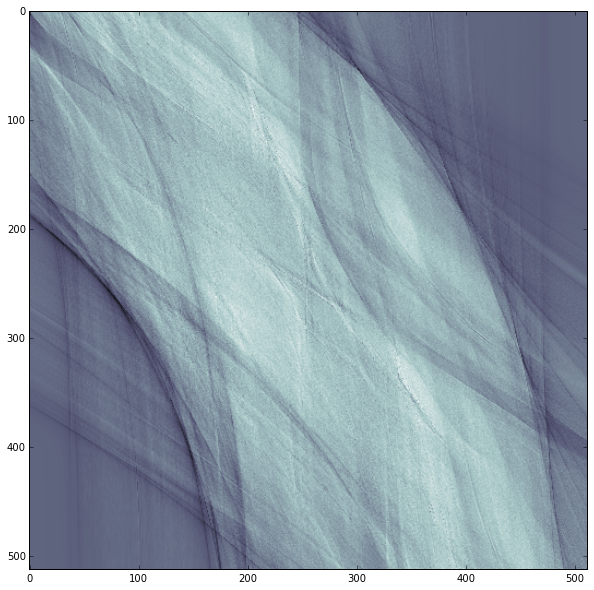

In [86]:
%run P2serial

In [237]:
%%writefile P2a.py
from mpi4py import MPI
import numpy as np
import time
import matplotlib.pyplot as plt
import math
plt.ion()         # Allow interactive updates to the plots

from P2serial import data_transformer, get_data

def parallel_superimpose(data, transformer, image_size, chunk_size, comm, p_root=0):
  '''The parallel dot-product of the arrays a and b.
  Assumes the arrays exist on process p_root and returns the result to
  process p_root.
  By default, p_root = process 0.'''
  rank = comm.Get_rank()
  pcount = comm.Get_size()

  print "rank: %d" %rank

  if rank == 0: # send the data
    for i in np.arange(1,pcount):
        start, end = i*chunk_size, (i+1)*chunk_size
        comm.Send([data[start:end, :], MPI.DOUBLE], dest=i, tag=0)    
    data = data[(rank*chunk_size): ((rank+1)*chunk_size), :]


  if rank != 0: # receive the data
    data = np.empty((chunk_size, 6144), dtype=np.float64)
    comm.Recv([data, MPI.DOUBLE], source=p_root, tag=0)

  #  Save the number of tasks to a varaible

  # Start and end indices of the local dot product
  start, end = rank*chunk_size, (rank+1)*chunk_size
  # sanity check print statements
  print "Rank %d, start: %d, end: %d, num_elem: %d, pcount: %d" % (rank, start, end, end-start, pcount)

  # Compute the partial images
  local_superimposed = reduce(lambda image, k: image + transformer.transform(data[k-start, :], -(k+1)*np.pi/sample_size), xrange(start,end))

  if rank != p_root: # send the data
    comm.Send([local_superimposed,  MPI.DOUBLE], dest=p_root, tag=1)    

  if rank == p_root: # receive the data
    for i in np.arange(1,pcount):
        data = np.empty([image_size, image_size], dtype=np.float64)
        comm.Recv([data,  MPI.DOUBLE], source=i, tag=1)    
        local_superimposed += data
        
  return local_superimposed

if __name__ == '__main__':
  comm = MPI.COMM_WORLD
  rank = comm.Get_rank()
  pcount = comm.Get_size()
  np.set_printoptions(threshold=np.nan)

  # Get big arrays on process 0
  data = None
  sample_size, image_size = 6144, 512
  numrows, numcols = 2048, 6144
  chunk_size = int(numrows / pcount)
  transformer = data_transformer(sample_size, image_size)

  if rank == 0:
    data = get_data("PA1Distro/TomoData.bin")

  # Compute the dot product in parallel
  comm.barrier()
  p_start = MPI.Wtime()
  p_superimposed = parallel_superimpose(data, transformer, image_size, chunk_size, comm)
  comm.barrier()
  p_stop = MPI.Wtime()

  if rank == 0:
    plt.imsave('P2a.png', np.mat(p_superimposed), cmap='bone')
    
    s_start = time.time()
    s_superimposed = reduce(lambda image, k: image + transformer.transform(data[k-1, :], -k*np.pi/sample_size), np.arange(numrows))
    s_stop = time.time()
    plt.imsave('P2a_serial.png', np.mat(s_superimposed), cmap='bone')

    rel_error = np.linalg.norm(p_superimposed - s_superimposed) / np.linalg.norm(s_superimposed)
    print "Serial Time: %f secs" % (s_stop - s_start)
    print "Parallel Time: %f secs" % (p_stop - p_start)   
    print "Speedup : %fx" %  ((s_stop - s_start) / (p_stop - p_start))
    print "Relative Error  = %e" % rel_error
    if rel_error > 1e-10:
      print "***LARGE ERROR - POSSIBLE FAILURE!***"


Overwriting P2a.py


In [238]:
%%system 
mpiexec -n 4 python P2a.py

['rank: 0',
 'rank: 2',
 'rank: 1',
 'rank: 3',
 'Rank 1, start: 512, end: 1024, num_elem: 512, pcount: 4',
 'Rank 2, start: 1024, end: 1536, num_elem: 512, pcount: 4',
 'Rank 0, start: 0, end: 512, num_elem: 512, pcount: 4',
 'Rank 3, start: 1536, end: 2048, num_elem: 512, pcount: 4',
 'computed superimposed on 3 thread',
 'sending from other nodes',
 'computed superimposed on 2 thread',
 'sending from other nodes',
 'computed superimposed on 0 thread',
 'receiving from root',
 'computed superimposed on 1 thread',
 'sending from other nodes',
 'Serial Time: 34.656525 secs',
 'Parallel Time: 10.032202 secs',
 'Speedup : 3.454528x',
 'Relative Error  = 1.712763e+04',
 '***LARGE ERROR - POSSIBLE FAILURE!***']

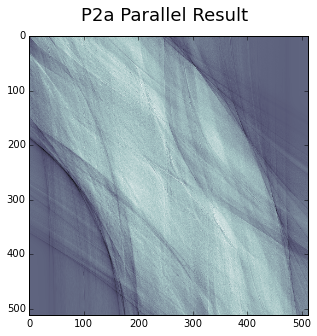

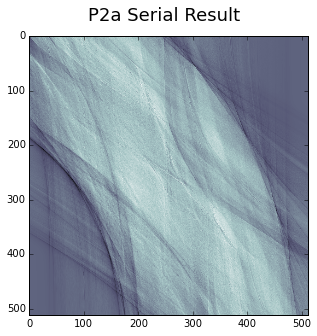

In [234]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(5,5),facecolor='w') 
fig.suptitle('P2a Parallel Result', fontsize=18)
p2b = mpimg.imread('P2a.png')
plt.imshow(p2b, cmap='bone')

fig = plt.figure(figsize=(5,5),facecolor='w') 
fig.suptitle('P2a Serial Result', fontsize=18)
p2b_serial = mpimg.imread('P2a_serial.png')
plt.imshow(p2b_serial, cmap='bone')

In [195]:
%%writefile P2b.py
from mpi4py import MPI
import numpy as np
import time
import matplotlib.pyplot as plt
import math
plt.ion()         # Allow interactive updates to the plots

from P2serial import data_transformer, get_data

def split_data(data, pcount):
  split = np.empty(4)
  chunk_size = int(data.shape[0]/pcount)
  for i in xrange(pcount):
      start, end = [rank*chunk_size, (rank+1)*chunk_size]
      split[i] = data[start:end, :]
  return split
  

def parallel_superimpose(data, transformer, image_size, comm, p_root=0):
  '''The parallel dot-product of the arrays a and b.
  Assumes the arrays exist on process p_root and returns the result to
  process p_root.
  By default, p_root = process 0.'''
  rank = comm.Get_rank()
  pcount = comm.Get_size()

  # Broadcast the arrays to all processes
  data = comm.scatter(data, root=p_root)

  #  Save the number of tasks to a variable
  chunk_size = int(data.shape[0])
  # Start and end indices of the local dot product
  start, end = rank*chunk_size, (rank+1)*chunk_size

  # sanity check print statements
  print "Rank %d, start: %d, end: %d, num_elem: %d, pcount: %d" % (rank, start, end, end-start, pcount)

  # Compute the partial images
  local_superimposed = reduce(lambda image, k: image + transformer.transform(data[k-start, :], -(k+1)*np.pi/sample_size), xrange(start,end))
  superimposed = comm.reduce(local_superimposed, root=p_root)
  return superimposed

if __name__ == '__main__':
  comm = MPI.COMM_WORLD
  rank = comm.Get_rank()
  pcount = comm.Get_size()

  np.set_printoptions(threshold=np.nan)

  # Get big arrays on process 0
  data = None
  sample_size, image_size = 6144, 512
  numrows, numcols = 2048, 6144
  transformer = data_transformer(sample_size, image_size)
  indices = {}

  if rank == 0:
    data = get_data("PA1Distro/TomoData.bin")
    split_data = np.array_split(data, pcount)

  # Compute the dot product in parallel
  comm.barrier()
  p_start = MPI.Wtime()
  p_superimposed = parallel_superimpose(split_data, transformer, image_size, comm)
  comm.barrier()
  p_stop = MPI.Wtime()
  
  if rank == 0:
    plt.imsave('P2b.png', np.mat(p_superimposed), cmap='bone')
    
    s_start = time.time()
    s_superimposed = reduce(lambda image, k: image + transformer.transform(data[k-1, :], -k*np.pi/sample_size), np.arange(numrows))
    s_stop = time.time()
    plt.imsave('P2b_serial.png', np.mat(s_superimposed), cmap='bone')

    rel_error = np.linalg.norm(p_superimposed - s_superimposed) / np.linalg.norm(s_superimposed)
    print "Serial Time: %f secs" % (s_stop - s_start)
    print "Parallel Time: %f secs" % (p_stop - p_start)   
    print "Speedup : %fx" %  ((s_stop - s_start) / (p_stop - p_start))
    print "Relative Error  = %e" % rel_error
    if rel_error > 1e-10:
      print "***LARGE ERROR - POSSIBLE FAILURE!***"


Overwriting P2b.py


In [196]:
%%system 
mpiexec -n 4 python P2b.py

^C


[]

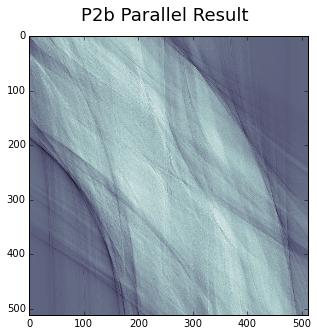

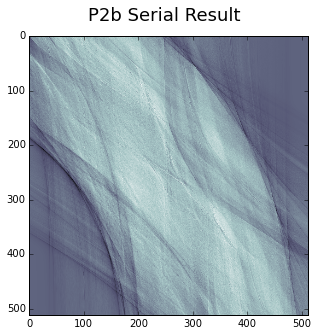

In [239]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(5,5),facecolor='w') 
fig.suptitle('P2b Parallel Result', fontsize=18)
p2b = mpimg.imread('P2b.png')
plt.imshow(p2b, cmap='bone')

fig = plt.figure(figsize=(5,5),facecolor='w') 
fig.suptitle('P2b Serial Result', fontsize=18)
p2b_serial = mpimg.imread('P2b_serial.png')
plt.imshow(p2b_serial, cmap='bone')

#f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(5,5))
#ax1.imshow(p2b_serial, cmap='bone')
#ax1.set_title('P2b Serial Result')
#ax2.imshow(p2b, cmap='bone')
#ax2.set_title('P2b Parallel Result')

3. Domain Decomposition
======

P3Serial.py
--

In [246]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpi4py import MPI
plt.ion()

class MeshPlotter3D:
    '''A class to help with 3D mesh plotting'''
    def __init__(self):
        '''Perform the required precomputation and make a dummy plot'''
        self.fig = plt.figure()
        self.axes = Axes3D(self.fig)
        self.mesh = self.axes.plot_wireframe(0, 0, 0)  # Dummy mesh
        self.axes.set_xlabel('I')
        self.axes.set_ylabel('J')

    def __plot_figure(self, X, Y, Z, zMin=-0.25, zMax=0.5):
        '''Private helper function to plot
        the (x,y,z) triples in the 2D arrays X, Y, Z'''
        self.mesh.remove()
        self.mesh = self.axes.plot_wireframe(X, Y, Z)
        self.axes.set_zlim3d(zMin, zMax);

    def draw_now(self, I, J, u):
        '''Update the plot with the data from u'''
        self.__plot_figure(I, J, u)
        plt.draw();

    def save_now(self, I, J, u, filename):
        '''Update the plot with the data from u'''
        self.__plot_figure(I, J, u)
        self.fig.savefig(filename)


class MeshPlotter3DParallel:
  '''A class to help with 3D interactive plotting from distributed data'''
  def __init__(self, comm=MPI.COMM_WORLD):
    '''Perform the required precomputation and make an initial plot'''
    self.comm = comm
    if self.comm.Get_rank() == 0:
      self.plotter = MeshPlotter3D()

  def __gather_data(self, I, J, u):
    # Sanity check
    assert I.size == J.size == u.size
    # TODO: Generalize beyond integers?
    assert I.dtype == J.dtype == np.int64 or I.dtype == J.dtype == np.int32

    # Get the size of each distributed portion
    counts = self.comm.gather(u.size, root=0)
    totalsize = np.sum(counts)

    # Allocate a buffer
    if self.comm.Get_rank() == 0:
      I0 = np.zeros(totalsize, dtype=I.dtype)
      J0 = np.zeros(totalsize, dtype=I.dtype)
      u0 = np.zeros(totalsize, dtype=u.dtype)
    else:
      I0, J0, u0 = None, None, None

    # Gather the data with vector-gathers
    self.comm.Gatherv(sendbuf=I.reshape(I.size),
                      recvbuf=(I0, (counts, None)), root=0)
    self.comm.Gatherv(sendbuf=J.reshape(J.size),
                      recvbuf=(J0, (counts, None)), root=0)
    self.comm.Gatherv(sendbuf=u.reshape(u.size),
                      recvbuf=(u0, (counts, None)), root=0)

    # Reorganize
    if self.comm.Get_rank() == 0:
            i0min, j0min = I0.min(), J0.min()
            I0 -= i0min
            J0 -= j0min
            u = np.zeros((I0.max()+1, J0.max()+1))
            I, J = np.zeros(u.shape), np.zeros(u.shape)
            u[I0,J0], I[I0,J0], J[I0,J0] = u0, I0+i0min, J0+j0min
            return I, J, u
    return None, None, None

  def draw_now(self, I, J, u):
    I, J, u = self.__gather_data(I, J, u)
    if self.comm.Get_rank() == 0:
      self.plotter.draw_now(I, J, u)

  def save_now(self, I, J, u, filename):
    I, J, u = self.__gather_data(I, J, u)
    if self.comm.Get_rank() == 0:
      self.plotter.save_now(I, J, u, filename)


if __name__ == '__main__':
    # Small parallel example: oscillating membrane (no communication)
    import sys

    # Global constants
    xMin, xMax = 0.0, 1.0     # Domain boundaries
    yMin, yMax = 0.0, 1.0     # Domain boundaries
    Nx = 64                   # Number of total grid points in x
    Ny = Nx                   # Number of total grid points in y
    dx = (xMax-xMin)/(Nx-1)   # Grid spacing, Delta x
    dy = (yMax-yMin)/(Ny-1)   # Grid spacing, Delta y
    dt = 0.4 * dx             # Time step (Magic factor of 0.4)
    T = 7                     # Time end
    omega = 2.0 * np.pi       # Oscillator frequency

    # Get MPI data
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()

    # Get Px and Py from command line
    try:
        Px = int(sys.argv[1])
        Py = int(sys.argv[2])
    except:
        print 'Usage: mpiexec -n (Px*Py) python Plotter3DCS205.py Px Py'
        sys.exit()

    # Sanity check
    assert Px*Py == MPI.COMM_WORLD.Get_size()

    # Create row and column communicators
    comm_col  = comm.Split(rank%Px)
    comm_row  = comm.Split(rank/Px)
    # Get the row and column indices for this process
    p_row     = comm_col.Get_rank()
    p_col     = comm_row.Get_rank()

    # Local constants
    Nx_local = Nx/Px          # Number of local grid points in x
    Ny_local = Ny/Py          # Number of local grid points in y

        # The global indices: I[i,j] and J[i,j] are indices of u[i,j]
    [I,J] = np.mgrid[(Nx_local*p_col):(Nx_local*(p_col+1)),
                         (Ny_local*p_row):(Ny_local*(p_row+1))]

    # Plot data using parallel plotter -- Gather the data and create one plot
    plotter = MeshPlotter3DParallel()

    # Plot data using a serial plotter -- Create one plot for each process
    #plotter = MeshPlotter3D()

    for k,t in enumerate(np.arange(0,T,dt)):
        # Compute u
        u = 0.5 * np.sin(I*dx*np.pi) * np.sin(J*dy*np.pi) * np.cos(omega*t)

        # Print out the step and simulation time
        if rank == 0:
            print "Step: %d  Time: %f" % (k,t)
        # All processes draw the image. Comment when non-interactive.
        if k % 5 == 0:
            plotter.draw_now(I, J, u)

    # Save an image of the final data
    plotter.save_now(I, J, u, "Oscillator.png")


Usage: mpiexec -n (Px*Py) python Plotter3DCS205.py Px Py


SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


In [33]:
import numpy as np
from Plotter3DCS205 import MeshPlotter3D, MeshPlotter3DParallel

def initial_conditions(DTDX, X, Y):
  '''Construct the grid points and set the initial conditions.
  X[i,j] and Y[i,j] are the 2D coordinates of u[i,j]'''
  assert X.shape == Y.shape

  um = np.zeros(X.shape)     # u^{n-1}  "u minus"
  u  = np.zeros(X.shape)     # u^{n}    "u"
  up = np.zeros(X.shape)     # u^{n+1}  "u plus"
  # Define Ix and Iy so that 1:Ix and 1:Iy define the interior points
  Ix = u.shape[0] - 1
  Iy = u.shape[1] - 1
  # Set the interior points: Initial condition is Gaussian
  u[1:Ix,1:Iy] = np.exp(-50 * (X[1:Ix,1:Iy]**2 + Y[1:Ix,1:Iy]**2))
  # Set the ghost points to the boundary conditions
  set_ghost_points(u)
  # Set the initial time derivative to zero by running backwards
  apply_stencil(DTDX, um, u, up)
  um *= 0.5
  # Done initializing up, u, and um
  return up, u, um

def apply_stencil(DTDX, up, u, um):
  '''Apply the computational stencil to compute u^{n+1} -- "up".
  Assumes the ghost points exist and are set to the correct values.'''

  # Define Ix and Iy so that 1:Ix and 1:Iy define the interior points
  Ix = u.shape[0] - 1
  Iy = u.shape[1] - 1
  # Update interior grid points with vectorized stencil
  up[1:Ix,1:Iy] = ((2-4*DTDX)*u[1:Ix,1:Iy] - um[1:Ix,1:Iy]
                   + DTDX*(u[0:Ix-1,1:Iy  ] +
                           u[2:Ix+1,1:Iy  ] +
                           u[1:Ix  ,0:Iy-1] +
                           u[1:Ix  ,2:Iy+1]))

  # The above is a vectorized operation for the simple for-loops:
  #for i in range(1,Ix):
  #  for j in range(1,Iy):
  #    up[i,j] = ((2-4*DTDX)*u[i,j] - um[i,j]
  #               + DTDX*(u[i-1,j] + u[i+1,j] + u[i,j-1] + u[i,j+1]))

def set_ghost_points(u):
  '''Set the ghost points.
  In serial, the only ghost points are the boundaries.
  In parallel, each process will have ghost points:
      some will need data from neighboring processes,
      others will use these boundary conditions.'''
  # Define Nx and Ny so that Nx+1 and Ny+1 are the ghost points
  Nx = u.shape[0] - 2
  Ny = u.shape[1] - 2
  # Update ghost points with boundary condition
  u[0,:]    = u[2,:];       # u_{0,j}    = u_{2,j}      x = 0
  u[Nx+1,:] = u[Nx-1,:];    # u_{Nx+1,j} = u_{Nx-1,j}   x = 1
  u[:,0]    = u[:,2];       # u_{i,0}    = u_{i,2}      y = 0
  u[:,Ny+1] = u[:,Ny-1];    # u_{i,Ny+1} = u_{i,Ny-1}   y = 1


if __name__ == '__main__':
  # Global constants
  xMin, xMax = 0.0, 1.0     # Domain boundaries
  yMin, yMax = 0.0, 1.0     # Domain boundaries
  Nx = 64                   # Number of total grid points in x
  Ny = Nx                   # Number of total grid points in y
  dx = (xMax-xMin)/(Nx-1)   # Grid spacing, Delta x
  dy = (yMax-yMin)/(Ny-1)   # Grid spacing, Delta y
  dt = 0.4 * dx             # Time step (Magic factor of 0.4)
  T = 5                     # Time end
  DTDX = (dt*dt) / (dx*dx)  # Precomputed CFL scalar

  # The global indices: I[i,j] and J[i,j] are indices of u[i,j]
  [I,J] = np.mgrid[-1:Nx+1, -1:Ny+1]
  # Convenience so u[1:Ix,1:Iy] are all interior points
  Ix, Iy = Nx+1, Ny+1

  # Set the initial conditions
  up, u, um = initial_conditions(DTDX, I*dx-0.5, J*dy)

  # Setup the serial plotter -- one plot per process
  plotter = MeshPlotter3D()
  # Setup the parallel plotter -- one plot gathered from all processes
  #plotter = MeshPlotter3DParallel()

  for k,t in enumerate(np.arange(0,T,dt)):
    # Compute u^{n+1} with the computational stencil
    apply_stencil(DTDX, up, u, um)

    # Set the ghost points on u^{n+1}
    set_ghost_points(up)

    # Swap references for the next step
    # u^{n-1} <- u^{n}
    # u^{n}   <- u^{n+1}
    # u^{n+1} <- u^{n-1} to be overwritten in next step
    um, u, up = u, up, um

    # Output and draw Occasionally
    #print "Step: %d  Time: %f" % (k,t)
    if k % 5 == 0:
      plotter.draw_now(I[1:Ix,1:Iy], J[1:Ix,1:Iy], u[1:Ix,1:Iy])

  plotter.save_now(I[1:Ix,1:Iy], J[1:Ix,1:Iy], u[1:Ix,1:Iy], "FinalWave.png")


In [95]:
%%writefile P3a.py
import numpy as np
from Plotter3DCS205 import MeshPlotter3D, MeshPlotter3DParallel
from P3serial import apply_stencil
from mpi4py import MPI
import sys

def fix_border(u, p_row, p_col, Px, Py):
    Nx = u.shape[0] - 2
    Ny = u.shape[1] - 2
    if p_row==0:
        u[0,:] = u[2,:]
    if p_row==Px-1:
        u[Nx+1,:] = u[Nx-1,:];    # u_{Nx+1,j} = u_{Nx-1,j}   x = 1
    if p_col==0:
        u[:,0] = u[:,2]
    if p_col==Py-1:
        u[:,Ny+1] = u[:,Ny-1];    # u_{i,Ny+1} = u_{i,Ny-1}   y = 1

def set_ghost_points(cart_comm, i, p_row, p_col):
    north, south = cart_comm.Shift(0, 1)
    west, east = cart_comm.Shift(1, 1)
    recvbuf = np.empty(i.shape[0])

    #Send data to the process above
    sendbuf = np.copy(i[1, ])
    cart_comm.Sendrecv(sendbuf=sendbuf, dest=north, recvbuf=recvbuf, source=south)
    if south >= 0:
        i[-1, ] = recvbuf
        
    #Send data to the process below
    sendbuf = np.copy(i[-2, ])
    cart_comm.Sendrecv(sendbuf=sendbuf, dest=south, recvbuf=recvbuf, source=north)
    if north >= 0:
        i[0, ] = recvbuf
        
    #Send data to the process on the left
    sendbuf = np.copy(i[:, 1])
    cart_comm.Sendrecv(sendbuf=sendbuf, dest=west, recvbuf=recvbuf, source=east)
    if east >= 0:
        i[:,-1] = recvbuf
        
    #Send data to the process on the right
    sendbuf = np.copy(i[:,-2])
    cart_comm.Sendrecv(sendbuf=sendbuf, dest=east, recvbuf=recvbuf, source=west)
    if west >= 0:
        i[:,0] = recvbuf
    return i

def initial_conditions(DTDX, X, Y, cart_comm, p_row, p_col, Px, Py):
    '''Construct the grid points and set the initial conditions.
    X[i,j] and Y[i,j] are the 2D coordinates of u[i,j]'''
    assert X.shape == Y.shape

    um = np.zeros(X.shape)     # u^{n-1}  "u minus"
    u  = np.zeros(X.shape)     # u^{n}    "u"
    up = np.zeros(X.shape)     # u^{n+1}  "u plus"
    # Define Ix and Iy so that 1:Ix and 1:Iy define the interior points
    Ix = u.shape[0] - 1
    Iy = u.shape[1] - 1
    # Set the interior points: Initial condition is Gaussian
    u[1:Ix,1:Iy] = np.exp(-50 * (X[1:Ix,1:Iy]**2 + Y[1:Ix,1:Iy]**2))
    
    set_ghost_points(cart_comm, u, p_row, p_col)
    
    # Set the ghost points to the boundary conditions
    fix_border(u, p_row, p_col, Px, Py)
    
    # Set the initial time derivative to zero by running backwards
    apply_stencil(DTDX, um, u, up)
    
    set_ghost_points(cart_comm, up, p_row, p_col)
    fix_border(u, p_row, p_col, p_row, p_col)
    
    um *= 0.5
    # Done initializing up, u, and um
    return up, u, um


def wave_parallel(comm, Px, Py):
    cart_comm = comm.Create_cart([Px, Py])
    cart_rank = cart_comm.Get_rank()
    coord = cart_comm.Get_coords(cart_rank)

    # Get the row and column indices for this process
    p_row, p_col = coord[0], coord[1]

    # Local constants
    Nx_local = Nx/Py          # Number of local grid points in x
    Ny_local = Ny/Px          # Number of local grid points in y

    # The global indices: I[i,j] and J[i,j] are indices of u[i,j]
    startx, endx = (Ny_local*p_row-1), (Ny_local*(p_row+1)+1)
    starty, endy = (Nx_local*p_col-1), (Nx_local*(p_col+1)+1)
    [I,J] = np.mgrid[startx:endx, starty:endy]
    

    # Set the initial conditions
    up, u, um = initial_conditions(DTDX, I*dx-0.5, J*dy, cart_comm, p_row, p_col, Px, Py)

    plotter = MeshPlotter3DParallel()

    for k,t in enumerate(np.arange(0,T,dt)):

        # Compute u^{n+1} with the computational stencil
        apply_stencil(DTDX, up, u, um)

        up = set_ghost_points(cart_comm, up, p_row, p_col)
        # Set the ghost points on u^{n+1}
        fix_border(up, p_row, p_col, Px, Py)
    
        um, u, up = u, up, um

        if k % 5 == 0:
            plotter.draw_now(I[1:-1, 1:-1], J[1:-1, 1:-1], u[1:-1, 1:-1])
    plotter.save_now(I[1:-1,1:-1], J[1:-1,1:-1], u[1:-1,1:-1], "FinalWave-3a.png")

if __name__ == '__main__' :
    
    #Global constants
    xMin, xMax = 0.0, 1.0     # Domain boundaries
    yMin, yMax = 0.0, 1.0     # Domain boundaries
    Nx = 64                   # Number of total grid points in x
    Ny = 64                   # Number of total grid points in y
    dx = (xMax-xMin)/(Nx-1)   # Grid spacing, Delta x
    dy = (yMax-yMin)/(Ny-1)   # Grid spacing, Delta y
    dt = 0.4 * dx             # Time step (Magic factor of 0.4)
    T = 5                     # Time end
    DTDX = (dt*dt) / (dx*dx)  # Precomputed CFL scalar

    Px = int(sys.argv[1])
    Py = int(sys.argv[2])
    
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    comm.barrier()
    p_start = MPI.Wtime()
    wave_parallel(comm, Px, Py)
    comm.barrier()
    p_stop = MPI.Wtime()
    
    if rank == 0:
        print "Parallel Time: %f secs" % (p_stop - p_start)


Overwriting P3a.py


In [96]:
%%system 
mpiexec -n 16 python P3a.py 4 4

['Parallel Time: 3.162258 secs']

In [100]:
%%writefile P3b.py
import numpy as np
from Plotter3DCS205 import MeshPlotter3D, MeshPlotter3DParallel
from P3serial import apply_stencil
from P3a import initial_conditions, fix_border
from mpi4py import MPI
import sys

def set_ghost_points(cart_comm, i, p_row, p_col):
    north, south = cart_comm.Shift(0, 1)
    west, east = cart_comm.Shift(1, 1)
    recvbuf = np.empty(i.shape[0])

    #Send data to the process above
    sendbuf = np.copy(i[1,:])
    request_recv = cart_comm.Irecv(recvbuf, source=south)
    request_send = cart_comm.Isend(sendbuf, dest=north)
    request_recv.Wait()
    if south >= 0:
        i[-1,:] = recvbuf
    request_send.Wait()
    
    #Send data to the process below
    sendbuf = np.copy(i[-2, :])
    request_recv = cart_comm.Irecv(recvbuf, source=north)
    request_send = cart_comm.Isend(sendbuf, dest=south)
    request_recv.Wait()
    if north >= 0:
        i[0,:] = recvbuf
    request_send.Wait()
    
    #Send data to the process on the left
    sendbuf = np.copy(i[:, 1])
    request_recv = cart_comm.Irecv(recvbuf, source=east)
    request_send = cart_comm.Isend(sendbuf, dest=west)
    request_recv.Wait()
    if east >= 0:
        i[:,-1] = recvbuf
    request_send.Wait()

    #Send data to the process on the right
    sendbuf = np.copy(i[:,-2])
    request_recv = cart_comm.Irecv(recvbuf, source=west)
    request_send = cart_comm.Isend(sendbuf, dest=east)
    request_recv.Wait()
    if west >= 0:
        i[:,0] = recvbuf
    request_send.Wait()
    
    return i

def wave_parallel(comm, Px, Py):
    cart_comm = comm.Create_cart([Px, Py])
    cart_rank = cart_comm.Get_rank()
    coord = cart_comm.Get_coords(cart_rank)

    # Get the row and column indices for this process
    p_row, p_col = coord[0], coord[1]

    # Local constants
    Nx_local = Nx/Py          # Number of local grid points in x
    Ny_local = Ny/Px          # Number of local grid points in y

    # The global indices: I[i,j] and J[i,j] are indices of u[i,j]
    startx, endx = (Ny_local*p_row-1), (Ny_local*(p_row+1)+1)
    starty, endy = (Nx_local*p_col-1), (Nx_local*(p_col+1)+1)
    [I,J] = np.mgrid[startx:endx, starty:endy]

    # Set the initial conditions
    up, u, um = initial_conditions(DTDX, I*dx-0.5, J*dy, cart_comm, p_row, p_col, Px, Py)

    plotter = MeshPlotter3DParallel()

    for k,t in enumerate(np.arange(0,T,dt)):

        # Compute u^{n+1} with the computational stencil
        apply_stencil(DTDX, up, u, um)

        up = set_ghost_points(cart_comm, up, p_row, p_col)
        # Set the ghost points on u^{n+1}
        fix_border(up, p_row, p_col, Px, Py)
    
        um, u, up = u, up, um

        if k % 5 == 0:
            plotter.draw_now(I[1:-1, 1:-1], J[1:-1, 1:-1], u[1:-1, 1:-1])
    plotter.save_now(I[1:-1,1:-1], J[1:-1,1:-1], u[1:-1,1:-1], "FinalWave-3b.png")
    
if __name__ == '__main__' :
    
        #Global constants
    xMin, xMax = 0.0, 1.0     # Domain boundaries
    yMin, yMax = 0.0, 1.0     # Domain boundaries
    Nx = 64                   # Number of total grid points in x
    Ny = 64                   # Number of total grid points in y
    dx = (xMax-xMin)/(Nx-1)   # Grid spacing, Delta x
    dy = (yMax-yMin)/(Ny-1)   # Grid spacing, Delta y
    dt = 0.4 * dx             # Time step (Magic factor of 0.4)
    T = 5                     # Time end
    DTDX = (dt*dt) / (dx*dx)  # Precomputed CFL scalar
    
    Px = int(sys.argv[1])
    Py = int(sys.argv[2])
    
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    
    comm.barrier()
    p_start = MPI.Wtime()
    wave_parallel(comm, Px, Py)
    comm.barrier()
    p_stop = MPI.Wtime()
    
    if rank == 0:
        print "Parallel Time: %f secs" % (p_stop - p_start)


Overwriting P3b.py


In [101]:
%%system 
mpiexec -n 16 python P3b.py 4 4

['Parallel Time: 3.067342 secs']

4. Master/Slave
======

Question:
--

Two hypothetical students, Sally and John, propose different ways to divide up the image.
Sally implements the computation with P MPI processes by making process p compute all of the (valid) rows of p+nP for n = 0,1,2... and then using an MPI gather operation to collect all of the values to the root process.

<hr/>
### Clarifying Example
<br/>
P = 4<br/>
100 rows x 100 cols<br/>
p + n*P<br/>

p = 0, r = 4n<br/>
rows: [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96]<br/>
p = 1, r = 1 + 4n<br/>
rows: [1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93, 97]<br/>
p = 2,  r = 1 + 4n<br/>
rows: [2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66, 70, 74, 78, 82, 86, 90, 94, 98]<br/>
p = 3,  r = 1 + 4n<br/>
rows: [3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 99]<br/>


John’s strategy, also with P MPI processes, is to make process p copmile all of the (valid) rows pN,pN + 1,pN + 2,...,pN + (N − 1) where n = ceil(height/P) and then use an MPI gather operation to collect all of the values to the root process.

N = ceil(100/4) = 25<br/>
p = 0, rows = 0 .. 24<br/>
p = 1, rows = 25..49<br/>
p = 2, rows = 50..74<br/>
p = 3, rows = 75..100<br/>

### Analysis
John's strategy will sample at parts of the mandelbrot set that will require an uneven amount of iterations. In sampling the entire matrix more uniformly and holistically, Sally's strategy avoids the problem of locality which John's Strategy suffers. Therefore, Sally's strategy is better and so Sally should get the A.

### P4Serial.py

Line 0 with y = -1.250000
Line 1 with y = -1.247556
Line 2 with y = -1.245112
Line 3 with y = -1.242669
Line 4 with y = -1.240225
Line 5 with y = -1.237781
Line 6 with y = -1.235337
Line 7 with y = -1.232893
Line 8 with y = -1.230450
Line 9 with y = -1.228006
Line 10 with y = -1.225562
Line 11 with y = -1.223118
Line 12 with y = -1.220674
Line 13 with y = -1.218231
Line 14 with y = -1.215787
Line 15 with y = -1.213343
Line 16 with y = -1.210899
Line 17 with y = -1.208456
Line 18 with y = -1.206012
Line 19 with y = -1.203568
Line 20 with y = -1.201124
Line 21 with y = -1.198680
Line 22 with y = -1.196237
Line 23 with y = -1.193793
Line 24 with y = -1.191349
Line 25 with y = -1.188905
Line 26 with y = -1.186461
Line 27 with y = -1.184018
Line 28 with y = -1.181574
Line 29 with y = -1.179130
Line 30 with y = -1.176686
Line 31 with y = -1.174242
Line 32 with y = -1.171799
Line 33 with y = -1.169355
Line 34 with y = -1.166911
Line 35 with y = -1.164467
Line 36 with y = -1.162023
Line 37 wit

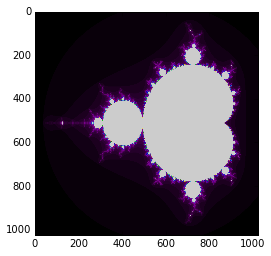

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import time

def mandelbrot(x, y):
  '''Compute a Mandelbrot pixel -- Unoptimized'''
  z = c = complex(x,y)
  it, maxit = 0, 511
  while abs(z) < 2 and it < maxit:
    z = z*z + c
    it += 1
  return it

# Global variables, can be used by any process
minX,  maxX   = -2.1, 0.7
minY,  maxY   = -1.25, 1.25
width, height = 2**10, 2**10

if __name__ == '__main__':
  C = np.zeros([height,width], dtype=np.uint16)

  start_time = time.time()
  for i,y in enumerate(np.linspace(minY, maxY, height)):
    print "Line %d with y = %f" % (i, y)
    for j,x in enumerate(np.linspace(minX, maxX, width)):
      C[i,j] = mandelbrot(x,y)
  end_time = time.time()

  print "Time: %f secs" % (end_time - start_time)
  plt.imsave('Mandelbrot_serial.png', C, cmap='spectral')
  plt.imshow(C, aspect='equal', cmap='spectral')
  plt.show()


# P4.py

In [102]:
%%writefile P4.py
### P4.py
from mpi4py import MPI
import matplotlib.pyplot as plt
import numpy as np
import time


def mandelbrot(x,y):
    z = c = complex(x,y)
    it, maxit = 0, 511
    while abs(z) < 2 and it < maxit:
        z = z*z + c
        it += 1
    return it

def master(comm):
    image = np.zeros([numrows,numcols], dtype=np.uint16)   
    sent_rows = 0
    process = 1
 
    # Send the first batch of processes to the nodes.
    while process < size and sent_rows < numrows:
        comm.send(sent_rows, dest=process, tag=1)
        # print "Sending row",sent_rows,"to process",process
        sent_rows += 1
        process += 1
 
    # Wait for the data to come back
    received_processes = 0
    while received_processes < numrows:
        [process, row_number, row_data] = comm.recv(source=MPI.ANY_SOURCE, tag=1)
        image[row_number, :] = row_data
        # print "Recieved data from process", process
        received_processes += 1
 
        if sent_rows < numrows:
            comm.send(sent_rows, dest=process, tag=1)
            # print "Sending row",sent_rows,"to process",process
            sent_rows += 1
 
    # Send the shutdown signal
    for process in range(1,size):
        comm.send(-1, dest=process, tag=1)
 
    fig = plt.figure() 
    fig.suptitle('Mandelbrot Image', fontsize=18)
    plt.imshow(image, cmap='Spectral', aspect='equal')
    plt.imsave('Mandelbrot_parallel.png', image, cmap='spectral')
    plt.show()

def slave(comm):
    while True:
        row_number = comm.recv(source=0, tag=1)
        if row_number == -1: break
        yval = ylim[0] + ydelta*row_number
        
        row_data = np.empty(numcols, dtype=np.uint16)
        for idx, val in enumerate(np.linspace(xlim[0], xlim[1], numcols)):
            row_data[idx] = mandelbrot(val, yval)
            
        comm.send([rank, row_number, row_data], dest=0, tag=1)
        
if __name__ == '__main__':
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
     
    numrows, numcols = 2**10, 2**10
    
    xlim = [-2.1, 0.7]
    ylim = [-1.25, 1.25]
    ydelta = (ylim[1] - ylim[0]) / (numrows - 1)
    
    # This is the master node.
    if rank == 0:
        master(comm)
    else:
        slave(comm)

Overwriting P4.py


In [320]:
%%system 
mpiexec -n 4 python P4.py

[]

5. Extra Credit
======

##P4Sally.py

In [353]:
%%writefile P4Sally.py

import numpy as np
import matplotlib.pyplot as plt
import time
from mpi4py import MPI

def mandelbrot(x, y):
  z = c = complex(x,y)
  it, maxit = 0, 511
  while abs(z) < 2 and it < maxit:
    z = z*z + c
    it += 1
  return it


def getMyData(my_rows):
    my_data = np.empty((len(my_rows), numcols))
    for idx, row_num in enumerate(my_rows):
        yval = ylim[0] + ydelta*row_num
        for col_num, xval in enumerate(np.linspace(xlim[0], xlim[1], numcols)):
            my_data[idx, col_num] = mandelbrot(xval, yval)
    return my_data
    
# Global variables, can be used by any process
numcols, numrows = 2**10, 2**10
xlim = [-2.1, 0.7]
ylim = [-1.25, 1.25]
ydelta = (ylim[1] - ylim[0]) / (numrows - 1)


if __name__ == '__main__':
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    
        
    comm.barrier()
    p_start = MPI.Wtime()
    my_rows = xrange(rank, numrows, size)
    my_data = getMyData(my_rows) 
    data = comm.gather(my_data, root=0)
    comm.barrier()    
    p_stop = MPI.Wtime()
    if rank == 0:   
        C = np.zeros([numrows,numcols], dtype=np.uint16)
        for i in range(size):
            for idx, row in enumerate(xrange(rank, numrows, size)):
                C[row, :] = data[i][idx]
                
        print "Parallel Time: %f secs" % (p_stop - p_start)
        fig = plt.figure() 
        fig.suptitle('Mandelbrot Image (Sally)', fontsize=18)
        plt.imshow(C, cmap='spectral', aspect='equal')
        plt.imsave('Mandelbrot_sally.png', image, cmap='spectral') 
        plt.show()

        D = np.zeros([numrows,numcols], dtype=np.uint16)
        s_start_time = time.time()
        for i,y in enumerate(np.linspace(ylim[0], ylim[1], numrows)):
            for j,x in enumerate(np.linspace(xlim[0], xlim[1], numcols)):
                D[i,j] = mandelbrot(x,y)
        s_end_time = time.time()
        print "Serial Time: %f secs" % (s_end_time - s_start_time)

Overwriting P4Sally.py


In [354]:
%%system 
mpiexec -n 4 python P4Sally.py

['Parallel Time: 16.302411 secs', 'Serial Time: 52.770792 secs']

##P4John.py

In [93]:
%%writefile P4John.py

import numpy as np
import matplotlib.pyplot as plt
import time
from mpi4py import MPI
from math import ceil

def mandelbrot(x, y):
  z = c = complex(x,y)
  it, maxit = 0, 511
  while abs(z) < 2 and it < maxit:
    z = z*z + c
    it += 1
  return it

def getMyData(my_rows):
    my_data = np.empty((len(my_rows), numcols))
    for idx, row_num in enumerate(my_rows):
        yval = ylim[0] + ydelta*row_num
        for col_num, xval in enumerate(np.linspace(xlim[0], xlim[1], numcols)):
            my_data[idx, col_num] = mandelbrot(xval, yval)
    return my_data
    
# Global variables, can be used by any process
numcols, numrows = 2**10, 2**10
xlim = [-2.1, 0.7]
ylim = [-1.25, 1.25]
ydelta = (ylim[1] - ylim[0]) / (numrows - 1)

if __name__ == '__main__':
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    N = int(ceil(numrows/size))
        
    comm.barrier()
    p_start = MPI.Wtime()
    my_rows = xrange(rank*N, rank*N+N)
    my_data = getMyData(my_rows) 
    data = comm.gather(my_data, root=0)
    comm.barrier()    
    p_stop = MPI.Wtime()
    
    if rank == 0:   
        C = np.zeros([numrows,numcols], dtype=np.uint16)
        for i in range(size):
            for idx, row in enumerate(xrange(i*N, i*N+N)):
                C[row, :] = data[i][idx]
 
        print "Parallel Time: %f secs" % (p_stop - p_start)
        fig = plt.figure() 
        fig.suptitle('Mandelbrot Image (John)', fontsize=18)
        plt.imshow(C, cmap='spectral', aspect='equal')
        plt.imsave('Mandelbrot_john.png', image, cmap='spectral') 
        plt.show()

        D = np.zeros([numrows,numcols], dtype=np.uint16)
        s_start_time = time.time()
        for i,y in enumerate(np.linspace(ylim[0], ylim[1], numrows)):
            for j,x in enumerate(np.linspace(xlim[0], xlim[1], numcols)):
                D[i,j] = mandelbrot(x,y)
        s_end_time = time.time()
        print "Serial Time: %f secs" % (s_end_time - s_start_time)

Overwriting P4John.py


In [94]:
%%system 
mpiexec -n 4 python P4John.py

['Parallel Time: 17.463029 secs', 'Serial Time: 41.258546 secs']